## 🐶 End-to-end Multil-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.


## 4. Features
Some information about the data:

•We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.

•There are 120 breeds of dogs (this means there are 120 different classes).

•There are around 10,000+ images in the training set (these images have labels).

•There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

In [3]:
import tensorflow as tf
print("TF version: " , tf.__version__)

TF version:  2.17.1


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.17.1
TF Hub version: 0.16.1
GPU available


## Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

In [5]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/dog-breed-identification/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


<Axes: xlabel='breed'>

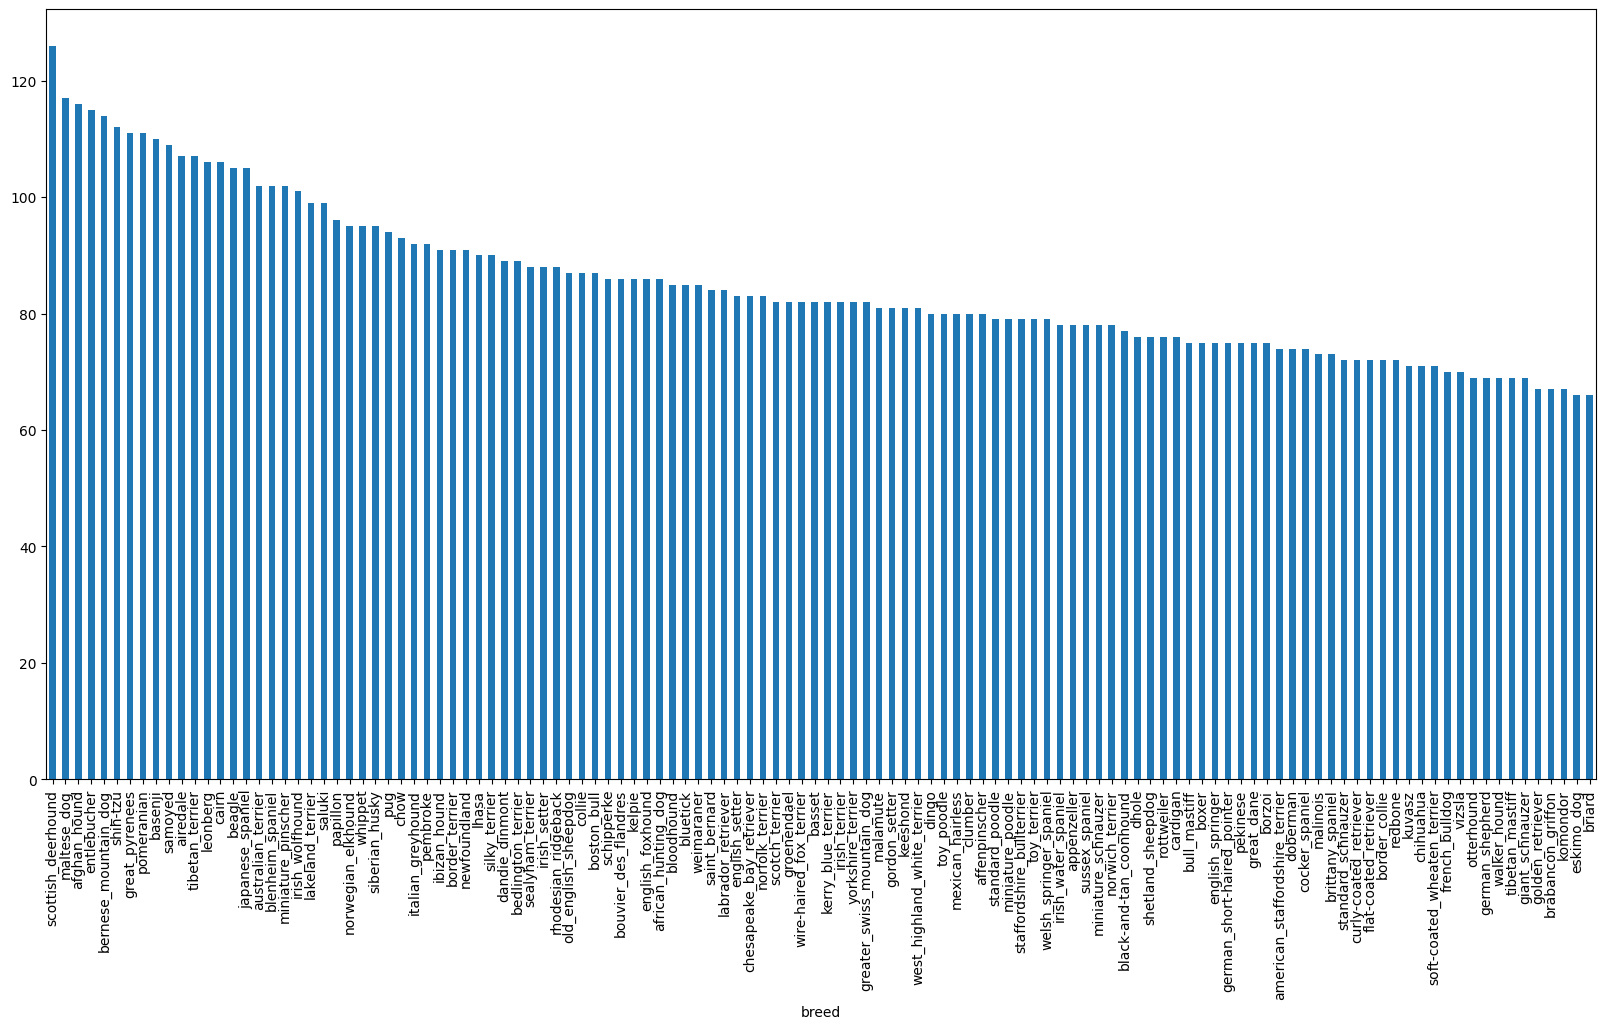

In [8]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [9]:
labels_csv["breed"].value_counts().median()

82.0

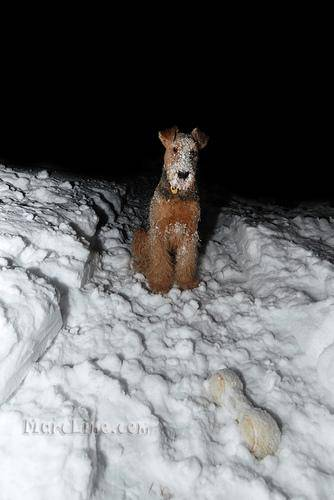

In [10]:
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/dog-breed-identification/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg")

### Getting images and their labels
Let's get a list of all of our image file pathnames.

In [11]:
filenames = ["drive/MyDrive/Dog Vision/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# length of train data
len(filenames)

10222

In [13]:
# Check whether number of filenames matches number of actual image files
import os

if(len(os.listdir("drive/MyDrive/Dog Vision/dog-breed-identification/train/")) == len(filenames)):
  print("Filenames match actual amount of data!")
else:
  print("Filenames do not match actual amount of data.")

Filenames match actual amount of data!


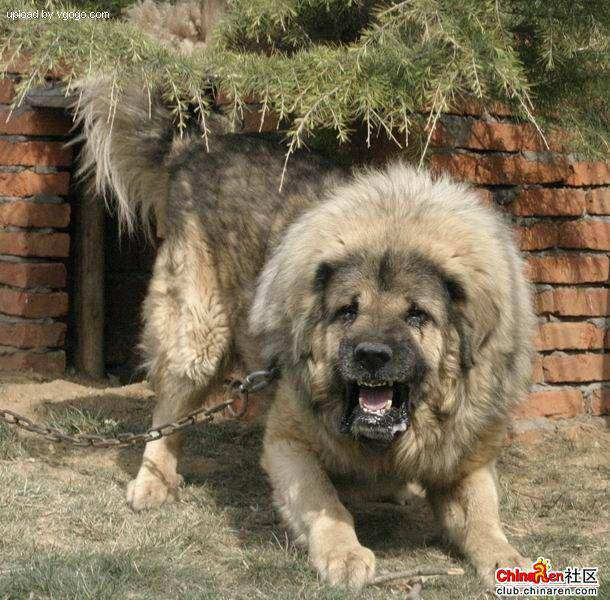

In [14]:
Image(filenames[9000])

In [15]:
labels_csv["breed"][9000]

'tibetan_mastiff'


Since we've now got our training image filepaths in a list, let's prepare our labels.

In [16]:
import numpy as np

labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len(labels)

10222

In [18]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [19]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [20]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [21]:
print(labels[0])

boston_bull


In [22]:
# Turn a single label into an array of booleans
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [23]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
# Example: Turning boolean array into integers
print(labels[0])    # original label
print(np.where(unique_breeds == labels[0]))    # index where label occurs
print(boolean_labels[0].argmax())        # index where label occurs in boolean array
print(boolean_labels[0].astype(int))     # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [26]:
filenames[:10]

['drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

In [27]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [28]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [29]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [30]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [31]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
     

## Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input

2. Use TensorFlow to read the file and save it to a variable, image

3. Turn our image (a jpg) into Tensors

4. Normalize our image (convert color channel values from from 0-255 to 0-1).

5. Resize the image to be a shape of (224, 224)

6. Return the modified image

In [32]:
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape   #(height, width, color_channels)

(257, 350, 3)

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
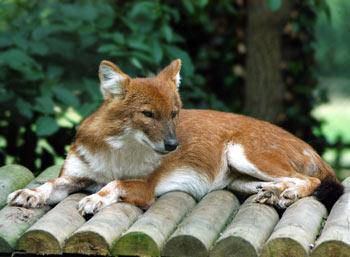

In [33]:
image

In [34]:
image.max(), image.min()

(255, 0)

In [35]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [36]:
# turn image into a tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [37]:
IMG_SIZE = 224

# Create a function for preprocessing images

def process_image(image_path, img_size = IMG_SIZE):

  # Read an image
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-225 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches
Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [38]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [39]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [40]:
# Turn data into batches

BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),    #filepaths
                                               tf.constant(y)))   #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # training dataset, shuffle it
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size = len(X))       # how many variables to shuffle
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [41]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [42]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

In [43]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))

  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")

In [44]:
# turn train_data into iterator
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [45]:
# train_images, train_labels = next(train_data.as_numpy_iterator())
# show_25_images(train_images, train_labels)

In [46]:
# val_images, val_labels = next(valid_data.as_numpy_iterator())
# show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:

•The input shape (our images shape, in the form of Tensors) to our model.

•The output shape (image labels, in the form of Tensors) of our model.

•The URL of the model we want to use from TensorFlow Hub

In [47]:
IMG_SIZE

224

In [48]:
# setup input and output shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]        # batch, height, width, colour channels
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Keras Deep Learning Model

•Takes the input shape, output shape and the model we've chosen as parameters.

•Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).

•Compiles the model (says it should be evaluated and improved).

•Builds the model (tells the model the input shape it'll be getting).
Returns the model.

In [49]:
# !pip install tensorflow_hub --upgrade

In [50]:
# pip install tf_keras

In [51]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf_keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf_keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf_keras.losses.CategoricalCrossentropy(),
      optimizer=tf_keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [52]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.


### TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

Load the TensorBoard notebook extension

Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.

Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [53]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [54]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [55]:
# Create early stopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [56]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [57]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model.

•Create a model using create_model()

•Setup a TensorBoard callback using create_tensorboard_callback()

•Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use

•Return the model

In [58]:
# !pip install -q -U tf_keras
# !pip install -q -U tensorflow

import tensorflow as tf
from tf_keras.callbacks import TensorBoard, EarlyStopping

In [59]:
# Build a function to train and return a trained model

def train_model():
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  # tensorboard = create_tensorboard_callback()

  tensorboard = tf_keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = valid_data,
            validation_freq = 1,
            callbacks=[tensorboard, early_stopping])

  return model

In [60]:
 model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 363s 14s/step - loss: 4.4964 - accuracy: 0.0938 - val_loss: 3.4849 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 7s 281ms/step - loss: 1.5864 - accuracy: 0.6963 - val_loss: 2.2444 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 8s 314ms/step - loss: 0.5538 - accuracy: 0.9450 - val_loss: 1.7350 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 8s 329ms/step - loss: 0.2415 - accuracy: 0.9912 - val_loss: 1.5433 - val_accuracy: 0.5900
Epoch 5/100
25/25 [==============================] - 7s 298ms/step - loss: 0.1440 - accuracy: 0.9950 - val_loss: 1.4614 - val_accuracy: 0.6050
Epoch 6/100
25/25 [==============================] - 7s 295ms/step - loss: 0.0980 - accuracy: 1.0000 - val_loss: 1.4182 - val_accuracy: 0.6250
Epoch 7/100
25/25 [==============================

In [61]:
# model performs better on training data - overfitting

### Checking the TensorBoard logs
The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [62]:
# %tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

## Making and evaluating predictions using a trained model


In [63]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [64]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 5s 108ms/step


array([[1.1797898e-03, 2.5543434e-04, 5.4189855e-05, ..., 1.5760728e-04,
        8.1170445e-05, 1.9541408e-03],
       [5.8610964e-04, 8.3320064e-04, 1.6050264e-03, ..., 5.5277877e-04,
        1.0533099e-03, 2.7599127e-04],
       [2.2030210e-06, 2.5130979e-05, 4.6096564e-05, ..., 4.1946928e-06,
        4.5476108e-06, 6.7518573e-05],
       ...,
       [3.3134864e-07, 3.9796000e-06, 1.1915091e-05, ..., 2.5778365e-06,
        1.6101725e-05, 8.8937950e-06],
       [9.3589053e-03, 1.7411048e-04, 1.2232760e-04, ..., 4.0241305e-04,
        7.9363745e-05, 9.3971705e-03],
       [1.1113860e-03, 9.2983610e-06, 4.1828067e-03, ..., 3.7800493e-03,
        3.1786249e-04, 1.0394303e-05]], dtype=float32)

In [65]:
predictions.shape

(200, 120)

In [66]:
len(y_val), len(unique_breeds)

(200, 120)

In [67]:
predictions[0]

array([1.1797898e-03, 2.5543434e-04, 5.4189855e-05, 4.5720164e-05,
       7.6917211e-05, 2.0761101e-05, 7.9258615e-03, 3.7670645e-04,
       5.6732395e-05, 3.4612580e-04, 6.5453275e-04, 3.3941219e-04,
       9.4443647e-05, 2.8631937e-05, 8.6992368e-05, 3.8726561e-04,
       9.3325752e-06, 1.2557168e-01, 7.3279612e-06, 4.4539200e-05,
       4.2809077e-04, 3.2848163e-04, 2.7863649e-05, 3.7670444e-04,
       4.1913710e-05, 1.5111832e-04, 4.4569114e-01, 1.3193508e-04,
       5.5878179e-04, 2.7697734e-04, 7.0827162e-05, 8.2183594e-04,
       2.6397864e-04, 4.5114179e-05, 1.2680047e-05, 6.4180684e-03,
       3.0540283e-05, 1.8832160e-04, 1.5657290e-05, 5.9608155e-05,
       1.3702421e-03, 1.2154335e-04, 9.9773388e-05, 3.9499337e-05,
       2.5633446e-04, 2.2853554e-05, 6.5966946e-05, 1.9843482e-04,
       2.8037568e-04, 1.6490328e-04, 4.7541042e-05, 2.9515466e-05,
       8.1645812e-05, 1.0949402e-05, 1.0601953e-05, 2.7546672e-05,
       4.3656910e-05, 1.4322210e-03, 2.9018271e-04, 1.7563318e

In [68]:
np.sum(predictions[0])

0.9999999

In [69]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[0])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}")

[1.1797898e-03 2.5543434e-04 5.4189855e-05 4.5720164e-05 7.6917211e-05
 2.0761101e-05 7.9258615e-03 3.7670645e-04 5.6732395e-05 3.4612580e-04
 6.5453275e-04 3.3941219e-04 9.4443647e-05 2.8631937e-05 8.6992368e-05
 3.8726561e-04 9.3325752e-06 1.2557168e-01 7.3279612e-06 4.4539200e-05
 4.2809077e-04 3.2848163e-04 2.7863649e-05 3.7670444e-04 4.1913710e-05
 1.5111832e-04 4.4569114e-01 1.3193508e-04 5.5878179e-04 2.7697734e-04
 7.0827162e-05 8.2183594e-04 2.6397864e-04 4.5114179e-05 1.2680047e-05
 6.4180684e-03 3.0540283e-05 1.8832160e-04 1.5657290e-05 5.9608155e-05
 1.3702421e-03 1.2154335e-04 9.9773388e-05 3.9499337e-05 2.5633446e-04
 2.2853554e-05 6.5966946e-05 1.9843482e-04 2.8037568e-04 1.6490328e-04
 4.7541042e-05 2.9515466e-05 8.1645812e-05 1.0949402e-05 1.0601953e-05
 2.7546672e-05 4.3656910e-05 1.4322210e-03 2.9018271e-04 1.7563318e-01
 7.7735289e-04 1.3631145e-05 4.2804936e-04 7.3872388e-06 2.7874921e-04
 1.6063313e-03 3.2732769e-05 9.7458709e-05 1.6446299e-03 3.0769770e-05
 2.847

In [70]:
unique_breeds[59]

'irish_wolfhound'

Note: Prediction probabilities are also known as confidence levels.

In [71]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [72]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [73]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [74]:
get_pred_label(val_labels[0])

'affenpinscher'

In [75]:
get_pred_label(labels[0])

'affenpinscher'

Now we've got ways to get:

•Prediction labels

•Validation labels (truth labels)

•Validation images
Let's make some function to make these all a bit more visaulize.

We'll create a function which:

•Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.

•Convert the prediction probabilities to a predicted label.

•Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [76]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob * 100),
                                    true_label),
                              color = color
                                    )

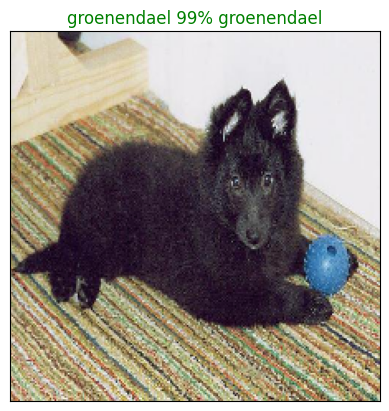

In [77]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

•Take an input of prediction probabilities array and a ground truth array and an integer

•Find the prediction using get_pred_label()

•Find the top 10:

  -Prediction probabilities indexes

  -Prediction probabilities values

  -Prediction labels

•Plot the top 10 prediction probability values and labels, coloring the true label green

In [78]:
predictions[0].argsort()[-10:][::-1]

array([ 26,  59,  17, 103, 102,  70,  73, 109,  83,   6])

In [79]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.44569114, 0.17563318, 0.12557168, 0.05825031, 0.05087266,
       0.02847563, 0.0191912 , 0.00897951, 0.00864011, 0.00792586],
      dtype=float32)

In [80]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")

  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

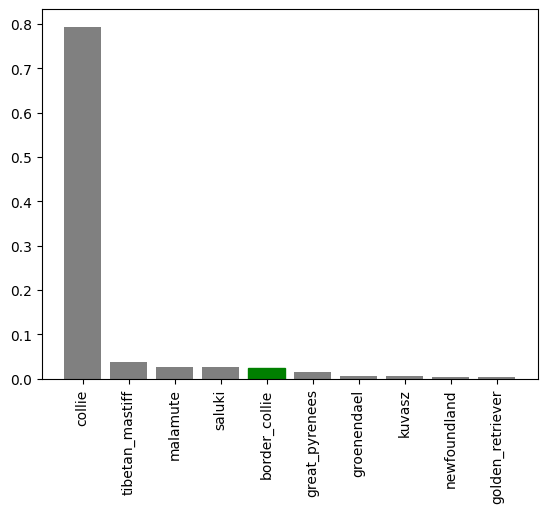

In [81]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

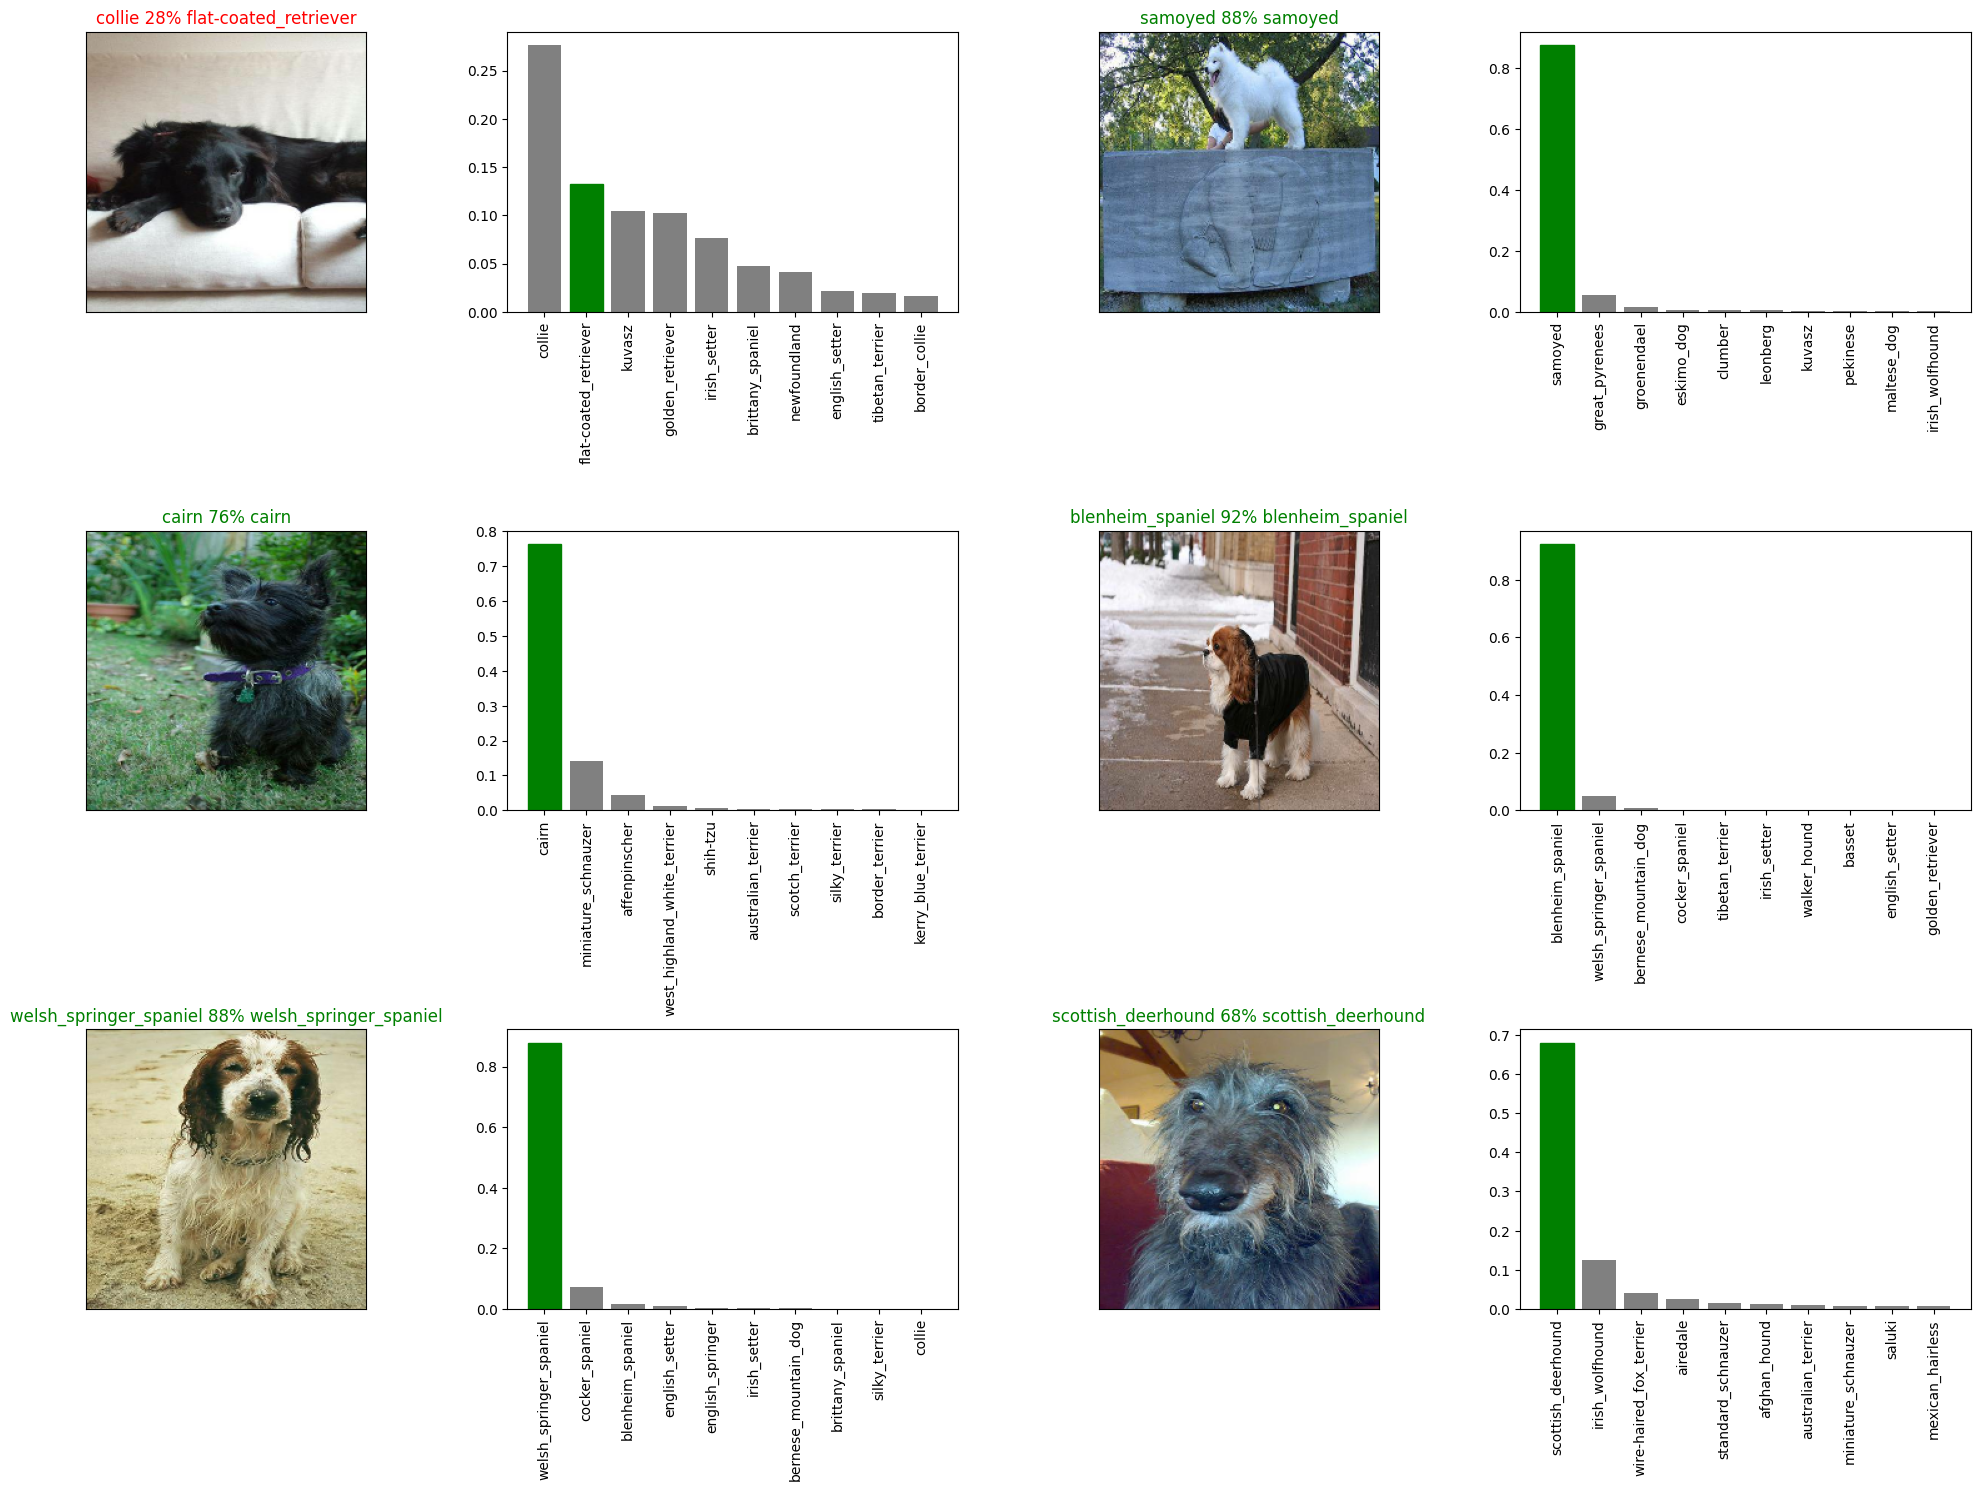

In [82]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10 * num_cols, 5 * num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2 * num_cols, 2 * i +2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [83]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [84]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf_keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [85]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20241122-13341732282462-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/My Drive/Dog Vision/models/20241122-13341732282462-1000-images-mobilenetv2-Adam.h5'

In [86]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20241030-02501730256602-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20241030-02501730256602-1000-images-mobilenetv2-Adam.h5


In [87]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 99ms/step - loss: 1.2945 - accuracy: 0.6450


[1.2945170402526855, 0.6449999809265137]

In [88]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 114ms/step - loss: 1.2490 - accuracy: 0.6750


[1.2490159273147583, 0.675000011920929]

## Training a big dog model 🐶 (on the full data)

In [89]:
len(X), len(y)

(10222, 10222)

In [90]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [91]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [92]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [93]:
# Create full model callbacks
full_model_tensorboard = tf_keras.callbacks.TensorBoard(log_dir='./logs',
                                                         histogram_freq=1,
                                                         write_graph=True,
                                                         write_images=True)
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf_keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [94]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 52s 148ms/step - loss: 1.3585 - accuracy: 0.6697
Epoch 2/100
320/320 [==============================] - 45s 142ms/step - loss: 0.4036 - accuracy: 0.8772
Epoch 3/100
320/320 [==============================] - 51s 160ms/step - loss: 0.2377 - accuracy: 0.9368
Epoch 4/100
320/320 [==============================] - 48s 149ms/step - loss: 0.1559 - accuracy: 0.9630
Epoch 5/100
320/320 [==============================] - 51s 159ms/step - loss: 0.1072 - accuracy: 0.9781
Epoch 6/100
320/320 [==============================] - 46s 143ms/step - loss: 0.0767 - accuracy: 0.9883
Epoch 7/100
320/320 [==============================] - 48s 151ms/step - loss: 0.0585 - accuracy: 0.9915
Epoch 8/100
320/320 [==============================] - 46s 142ms/step - loss: 0.0453 - accuracy: 0.9951
Epoch 9/100
320/320 [==============================] - 51s 161ms/step - loss: 0.0383 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 47s 147m

In [95]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20241122-13531732283628-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20241122-13531732283628-full-image-set-mobilenetv2-Adam.h5'

In [96]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20241030-03151730258131-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20241030-03151730258131-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

In [97]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7b357150635c250757363718e4dae86.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7b4b0e7d7d76f8dbd64920f34443b25.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e807c4b5025b0aa4dcbd5df2765aa8e4.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7fcdf9671a6593b638cbee42842f981.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e816f0027a2c6348dbf12b79c70541bc.jpg',
 'drive/My Drive/Dog Vision/dog-breed-identification/test/e806a67a05289ac6de6831001664b81b.jpg']

In [98]:
len(test_filenames)

10357

In [99]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [100]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [101]:
# Make predictions on test data batch using the loaded full model
# test_predictions = loaded_full_model.predict(test_data,
#                                              verbose=1)

In [102]:
# Save predictions (NumPy array) to csv file (for access later)
# np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [103]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [104]:
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]])

In [105]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

In [106]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [107]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [108]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e7e9624f2a2e61ab187358f5968bfde8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7b357150635c250757363718e4dae86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7b4b0e7d7d76f8dbd64920f34443b25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7e9dd51302fe08c1c89a550e183cf07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7dc8cc599049ea9fa2a172c88646c57,1.611965e-09,3.440864e-12,2.328344e-11,1.407994e-12,5.980330e-09,2.145339e-11,5.328517e-10,1.764934e-10,4.491057e-11,...,8.200658e-09,4.056766e-08,2.202154e-11,3.074556e-12,7.080598e-12,3.024534e-09,2.991727e-07,1.069177e-13,1.585305e-08,1.521617e-06
1,e7e9624f2a2e61ab187358f5968bfde8,3.178943e-10,3.200883e-14,1.853748e-10,1.954662e-13,8.682216e-07,3.362278e-07,2.264711e-06,9.995926e-01,1.876677e-10,...,3.441671e-07,1.129437e-04,6.675200e-09,1.690707e-06,6.804413e-10,5.923428e-09,5.574148e-09,7.005888e-08,1.888222e-08,2.569809e-10
2,e7b357150635c250757363718e4dae86,4.273011e-09,1.841395e-13,1.117849e-09,1.106639e-10,7.225005e-11,1.169239e-05,7.223256e-07,5.553372e-04,9.785655e-11,...,3.530463e-09,4.605002e-05,9.586189e-12,2.740325e-08,8.798643e-12,2.793681e-08,1.502214e-07,2.719492e-12,2.239271e-06,7.418608e-11
3,e7b4b0e7d7d76f8dbd64920f34443b25,5.227723e-14,3.371553e-14,1.638175e-11,5.283554e-12,7.160043e-08,1.832600e-13,6.625124e-13,1.087913e-13,8.482403e-11,...,5.968796e-12,1.492889e-13,2.230498e-06,4.158368e-10,9.999646e-01,3.224581e-13,1.426521e-11,2.974644e-12,8.130380e-13,6.134530e-11
4,e7e9dd51302fe08c1c89a550e183cf07,9.613753e-11,1.304277e-08,1.246931e-08,1.478856e-07,6.658420e-09,6.374474e-12,2.422878e-05,4.128350e-09,1.767556e-04,...,1.207746e-06,2.052871e-08,6.508744e-13,2.080402e-10,1.428936e-09,5.703394e-08,1.541623e-06,2.052792e-05,3.110282e-04,1.318874e-06


In [110]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

In [111]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [112]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/lui-peng-ybHtKz5He9Y-unsplash.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/anthony-maina-VJ2Yw2C2rGM-unsplash.jpg']

In [113]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [114]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 2s 2s/step


In [115]:
custom_preds.shape

(2, 120)

In [116]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['samoyed', 'golden_retriever']

In [117]:
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

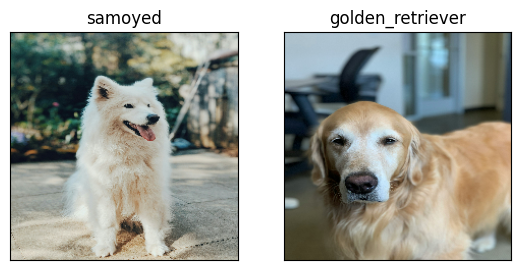

In [118]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)